<a href="https://colab.research.google.com/github/erinmcmahon26/Cervical_Cancer_Risk_Assessment/blob/main/CervicalCancerImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The models in this notebook aren't outputted in the notebook itself. I wrote them to databricks.

In [18]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Upload Kaggle API token

In [19]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


# Get Data From Kaggle

In [20]:
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

cervical-cancer-largest-dataset-sipakmed.zip: Skipping, found more recently modified local copy (use --force to force download)


# Unzip Kaggle Data

In [21]:
!unzip cervical-cancer-largest-dataset-sipakmed.zip

Archive:  cervical-cancer-largest-dataset-sipakmed.zip
replace im_Dyskeratotic/im_Dyskeratotic/001.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Set up MLFlow

https://medium.com/the-point-collections/intro-to-mlflow-with-colab-part-1-2-beb80c960ad9

In [22]:
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Username: rachelsickler2024@u.northwestern.edu
Password: 
Repeat for confirmation: 


In [23]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1726028455844524', creation_time=1674932314140, experiment_id='1726028455844524', last_update_time=1674932314140, lifecycle_stage='active', name='/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img', tags={'mlflow.experiment.sourceName': '/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'rachelsickler2024@u.northwestern.edu',
 'mlflow.ownerId': '382620755183241'}>

# Other Imports

In [88]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, make_scorer, recall_score, f1_score
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB5

# EDA

In [24]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from matplotlib.image import imread
# from os import makedirs
# from os import listdir
import os
# from shutil import copyfile
# from random import seed
# from random import random
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow import keras
# import sys
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

In [25]:
data=[]
labels=[]

height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

path1 = "im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "im_Parabasal/im_Parabasal/CROPPED/"
path5 = "im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

# print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray - 
labels = np.array(labels)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]


(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


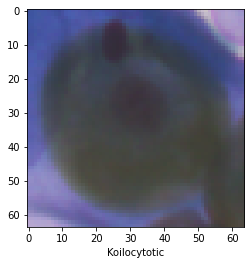

In [26]:
categories = ["Dyskeratotic", "Koilocytotic", "Metaplastic", "Parabasal", "Superficial-Intermediate"]

def show_the_image(i):
    plt.imshow(data[i])
    plt.xlabel(categories[labels[i]])
    
show_the_image(0)

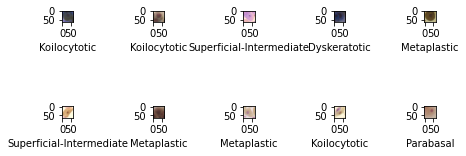

In [27]:
for i in range(10):
  # plt.subplot(330 + 1 + i) # rows, cols, idx
  plt.subplot(3, 5, i+1) # rows, cols, idx
  plt.imshow(data[i])
  plt.xlabel(categories[labels[i]])
  plt.tight_layout()
  plt.rcParams["figure.figsize"] = (10, 15)

In [28]:
for p in path:
  print(p, len(os.listdir(p)))

im_Dyskeratotic/im_Dyskeratotic/CROPPED/ 2439
im_Koilocytotic/im_Koilocytotic/CROPPED/ 2475
im_Metaplastic/im_Metaplastic/CROPPED/ 2379
im_Parabasal/im_Parabasal/CROPPED/ 2361
im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/ 2493


# Model 1

https://www.kaggle.com/code/sohamgovande/low-res-cervical-cancer-classification

[[  0 825]
 [  1 793]
 [  2 813]
 [  3 787]
 [  4 831]]
127/127 [==============================] - 52s 368ms/step


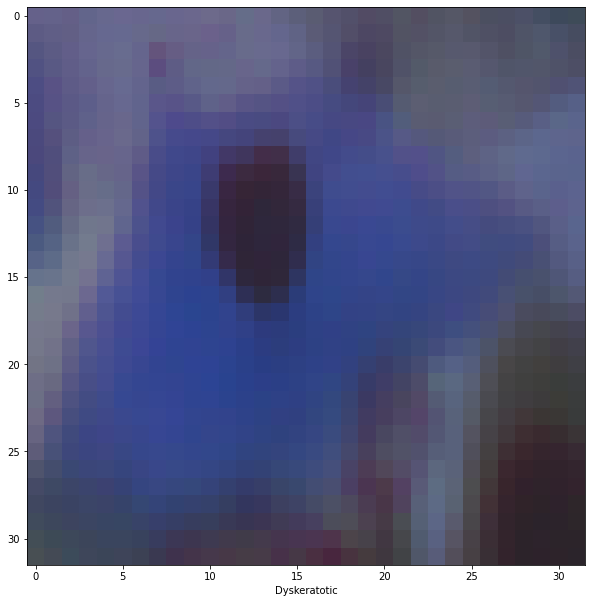

In [29]:
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
import tensorflow
import cv2
from keras.applications.efficientnet import EfficientNetB7
from sklearn.metrics import accuracy_score

imgdata = []
labels = []
###### FEEDBACK - how to determine the correct image size?
compressed_img_size = 32

celltypes = ['im_Koilocytotic', 'im_Metaplastic', 'im_Dyskeratotic', 'im_Parabasal', 'im_Superficial-Intermediate']
path = [celltype  + "/" + celltype + "/CROPPED/" for celltype in celltypes]

# Low pass filter
LOW_PASS_FILTER = False
# High pass filter
HIGH_PASS_FILTER = False

cur_label = -1
for celltype in path:
    cur_label += 1
    # Iterate over each cell's individual image
    cellimages = os.listdir(celltype)
    for cellimage in cellimages:
        if cellimage.lower().endswith(".bmp"):
            # Mark each cell with a cell type
            labels.append(cur_label)
            img = cv2.imread(celltype+cellimage)
            img = np.array(Image.fromarray(img, 'RGB').resize((compressed_img_size, compressed_img_size)))
            if LOW_PASS_FILTER:
                img = cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT)
            elif HIGH_PASS_FILTER:
                img = img - cv2.GaussianBlur(img, (3, 3), cv2.BORDER_DEFAULT) + 127
            imgdata.append(img)

labels = np.array(labels)
imgdata = np.array(imgdata)

# Shuffle/randomize order
random_order = np.arange(imgdata.shape[0])
np.random.shuffle(random_order)
labels = labels[random_order]
imgdata = imgdata[random_order]

# Get # of each cell type
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

# Used for generating figures (displaying cell images)
def disp_img(i):
    plt.imshow(imgdata[i])
    plt.xlabel(celltypes[labels[i]][len('im_'):])
    
for i in range(0, len(labels)):
    # Replace this with 0, 1, 2, 3, or 4 depending on the type of figure being generated
    if labels[i] == 2:
        disp_img(i)
        break

# Initialize neural networks
# do not include the fully-connected layer at the top of the network
model_efficientnet = EfficientNetB7(weights=None, include_top = False)
features_efficientnet = model_efficientnet.predict(imgdata, batch_size=32)

cur = features_efficientnet
extracted_features = []
zipped_data = zip(cur, labels)
for cur, label in zipped_data:
    cur = np.append(cur.reshape(cur.shape[0] * cur.shape[1] * cur.shape[2]), label)
    extracted_features.append(cur)
extracted_features = np.array(extracted_features)

# Use min-max scaling to normalize the data
X = extracted_features[:, 0:-1]
y = extracted_features[:, -1]
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# PCA
pca = PCA(n_components = 0.95) # represent 95% of the variation through principal components
pca.fit(scaled_X)
pca_x = pca.transform(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(pca_x, y, test_size = 0.2, random_state = 49)

# Neural network for classification
model = Sequential([
    Flatten(input_shape=(X_train.shape[1], 1)),
    Dense(256, activation='relu'),
    Dropout(rate=0.8),
    Dense(5, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

In [30]:
# Train the neural network
nn = model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
102/102 [==============================] - 1s 2ms/step - loss: 1.4550 - accuracy: 0.4310
Epoch 2/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0845 - accuracy: 0.5823
Epoch 3/50
102/102 [==============================] - 0s 2ms/step - loss: 0.9518 - accuracy: 0.6422
Epoch 4/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8736 - accuracy: 0.6761
Epoch 5/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8451 - accuracy: 0.6934
Epoch 6/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8000 - accuracy: 0.7110
Epoch 7/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7848 - accuracy: 0.7095
Epoch 8/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7450 - accuracy: 0.7339
Epoch 9/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7359 - accuracy: 0.7320
Epoch 10/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7284 - accuracy: 0.7357

In [31]:
# Predict on the test set and determine the accuracy
y_pred = np.argmax(model.predict(X_test), axis=1)
print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

26/26 [==============================] - 0s 2ms/step
Accuracy is: 83.08641975308642%


In [33]:
history_dict = nn.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

In [34]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy
45,0.516,0.810
46,0.496,0.816
47,0.520,0.810
48,0.505,0.808
49,0.509,0.806


In [37]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    return plt

In [44]:
CLASS_LIST = ['Koilocytotic', 'Metaplastic', 'Dyskeratotic', 'Parabasal', 'Superficial-Intermediate']

In [74]:
# compute and print classification report
print(classification_report(y_test, y_pred, target_names=CLASS_LIST))

                          precision    recall  f1-score   support

            Koilocytotic       0.86      0.71      0.78       163
             Metaplastic       0.87      0.87      0.87       166
            Dyskeratotic       0.85      0.96      0.90       145
               Parabasal       0.88      0.92      0.90       168
Superficial-Intermediate       0.80      0.81      0.80       168

                accuracy                           0.85       810
               macro avg       0.85      0.85      0.85       810
            weighted avg       0.85      0.85      0.85       810



In [72]:
report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)

In [73]:
report

{'Koilocytotic': {'precision': 0.8592592592592593,
  'recall': 0.7116564417177914,
  'f1-score': 0.7785234899328859,
  'support': 163},
 'Metaplastic': {'precision': 0.8682634730538922,
  'recall': 0.8734939759036144,
  'f1-score': 0.8708708708708709,
  'support': 166},
 'Dyskeratotic': {'precision': 0.852760736196319,
  'recall': 0.9586206896551724,
  'f1-score': 0.9025974025974026,
  'support': 145},
 'Parabasal': {'precision': 0.88,
  'recall': 0.9166666666666666,
  'f1-score': 0.8979591836734694,
  'support': 168},
 'Superficial-Intermediate': {'precision': 0.8,
  'recall': 0.8095238095238095,
  'f1-score': 0.8047337278106509,
  'support': 168},
 'accuracy': 0.8518518518518519,
 'macro avg': {'precision': 0.8520566937018941,
  'recall': 0.8539923166934109,
  'f1-score': 0.8509369349770559,
  'support': 810},
 'weighted avg': {'precision': 0.8519522253514464,
  'recall': 0.8518518518518519,
  'f1-score': 0.8498678097896056,
  'support': 810}}

In [61]:
report['accuracy']

0.8395061728395061

In [77]:
c = confusion_matrix(y_test, y_pred)
c

array([[116,   9,  15,   5,  18],
       [  7, 145,   0,   6,   8],
       [  5,   0, 139,   0,   1],
       [  0,   2,   5, 154,   7],
       [  7,  11,   4,  10, 136]])

In [79]:
c[1][1]

145

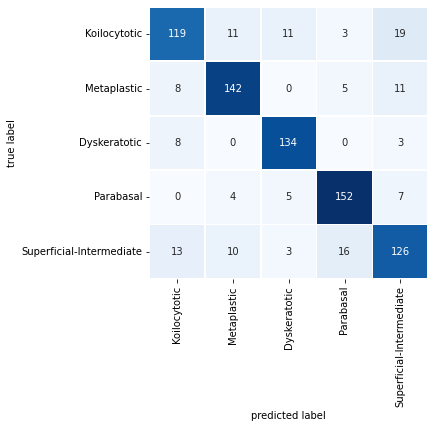

In [47]:
plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
plot.savefig("confusionMatrix.png")
plot.show()
plot.close()

mlflow.log_artifact("confusionMatrix.png")

In [32]:
import joblib
joblib.dump(model, 'model1.pkl')

['model1.pkl']

## MLFlow

In [64]:
# mlflow.end_run()

In [65]:
# write to an existing experiment
experiment = mlflow.get_experiment_by_name('/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img')
experiment_id = experiment.experiment_id
run_name = 'model1'
description = 'efficientnetb7, cnn'

In [84]:
import mlflow.tensorflow
mlflow.tensorflow.autolog(every_n_iter=1)

In [85]:
with mlflow.start_run(
        experiment_id=experiment_id,
        run_name=run_name,
        description=description,
) as run:

  # Low pass filter
  LOW_PASS_FILTER = False
  # High pass filter
  HIGH_PASS_FILTER = False

  # Initialize neural networks
  # do not include the fully-connected layer at the top of the network
  model_efficientnet = EfficientNetB7(weights=None, include_top = False)
  features_efficientnet = model_efficientnet.predict(imgdata, batch_size=32)

  cur = features_efficientnet
  extracted_features = []
  zipped_data = zip(cur, labels)
  for cur, label in zipped_data:
      cur = np.append(cur.reshape(cur.shape[0] * cur.shape[1] * cur.shape[2]), label)
      extracted_features.append(cur)
  extracted_features = np.array(extracted_features)

  # Use min-max scaling to normalize the data
  X = extracted_features[:, 0:-1]
  y = extracted_features[:, -1]
  scaler = MinMaxScaler()
  scaled_X = scaler.fit_transform(X)

  # PCA
  pca = PCA(n_components = 0.95) # represent 95% of the variation through principal components
  pca.fit(scaled_X)
  pca_x = pca.transform(scaled_X)

  X_train, X_test, y_train, y_test = train_test_split(pca_x, y, test_size = 0.2, random_state = 49)

  # Neural network for classification
  model = Sequential([
      Flatten(input_shape=(X_train.shape[1], 1)),
      Dense(256, activation='relu'),
      Dropout(rate=0.8),
      Dense(5, activation='softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',  optimizer='adam', metrics=['accuracy'])

  # Train the neural network
  nn = model.fit(X_train, y_train, batch_size=32, epochs=50)

  # Predict on the test set and determine the accuracy
  y_pred = np.argmax(model.predict(X_test), axis=1)
  print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

  # compute and print classification report
  confusion = confusion_matrix(y_test, y_pred)

  # compute and print classification report
  # print(classification_report(y_test, y_pred))
  plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
  plot.savefig("confusionMatrix.png")
  # plot.show()
  plot.close()
  mlflow.log_artifact("confusionMatrix.png")

  report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)

  metrics = {}
  metrics['Koilocytotic_precision'] = report['Koilocytotic']['precision']
  metrics['Koilocytotic_recall'] = report['Koilocytotic']['recall']
  metrics['Koilocytotic_f1'] = report['Koilocytotic']['f1-score']
  metrics['Koilocytotic_support'] = report['Koilocytotic']['support']
  metrics['Metaplastic_precision'] = report['Metaplastic']['precision']
  metrics['Metaplastic_recall'] = report['Metaplastic']['recall']
  metrics['Metaplastic_f1'] = report['Metaplastic']['f1-score']
  metrics['Metaplastic_support'] = report['Metaplastic']['support']
  metrics['Dyskeratotic_precision'] = report['Dyskeratotic']['precision']
  metrics['Dyskeratotic_recall'] = report['Dyskeratotic']['recall']
  metrics['Dyskeratotic_f1'] = report['Dyskeratotic']['f1-score']
  metrics['Dyskeratotic_support'] = report['Dyskeratotic']['support']
  metrics['Parabasal_precision'] = report['Parabasal']['precision']
  metrics['Parabasal_recall'] = report['Parabasal']['recall']
  metrics['Parabasal_f1'] = report['Parabasal']['f1-score']
  metrics['Parabasal_support'] = report['Parabasal']['support']
  metrics['SI_precision'] = report['Superficial-Intermediate']['precision']
  metrics['SI_recall'] = report['Superficial-Intermediate']['recall']
  metrics['SI_f1'] = report['Superficial-Intermediate']['f1-score']
  metrics['SI_support'] = report['Superficial-Intermediate']['support']
  metrics['accuracy'] = report['accuracy']
  metrics['tp_Koilocytotic'] = confusion[0][0]
  metrics['tp_Metaplastic'] = confusion[1][1]
  metrics['tp_Dyskeratotic'] = confusion[2][2]
  metrics['tp_Parabasal'] = confusion[3][3]
  metrics['tp_SI'] = confusion[4][4]
  metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted')
  metrics['low_pass_filer'] = LOW_PASS_FILTER
  metrics['high_pass_filter'] = HIGH_PASS_FILTER

  mlflow.log_metrics(metrics)

  joblib.dump(model, 'model1.pkl')
  mlflow.log_artifact('model1.pkl')

127/127 [==============================] - 54s 373ms/step
Epoch 1/50
102/102 [==============================] - 1s 4ms/step - loss: 1.5256 - accuracy: 0.4159
Epoch 2/50
102/102 [==============================] - 0s 2ms/step - loss: 1.0873 - accuracy: 0.5783
Epoch 3/50
102/102 [==============================] - 0s 2ms/step - loss: 0.9577 - accuracy: 0.6406
Epoch 4/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8837 - accuracy: 0.6761
Epoch 5/50
102/102 [==============================] - 0s 2ms/step - loss: 0.8335 - accuracy: 0.6974
Epoch 6/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7962 - accuracy: 0.7061
Epoch 7/50
102/102 [==============================] - 0s 4ms/step - loss: 0.7768 - accuracy: 0.7228
Epoch 8/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7353 - accuracy: 0.7311
Epoch 9/50
102/102 [==============================] - 0s 2ms/step - loss: 0.7166 - accuracy: 0.7410
Epoch 10/50
102/102 [=====================

2023/01/28 21:48:52 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


26/26 [==============================] - 0s 2ms/step
Accuracy is: 83.08641975308642%


# Model 2

https://www.kaggle.com/code/kanishk26/sipkamed-dataset

In [89]:
data=[]
labels=[]

height = 64
width = 64
channels = 3
classes = 43
n_inputs = height * width * channels

path1 = "im_Dyskeratotic/im_Dyskeratotic/CROPPED/"
path2 = "im_Koilocytotic/im_Koilocytotic/CROPPED/"
path3 = "im_Metaplastic/im_Metaplastic/CROPPED/"
path4 = "im_Parabasal/im_Parabasal/CROPPED/"
path5 = "im_Superficial-Intermediate/im_Superficial-Intermediate/CROPPED/"

path = [path1, path2, path3, path4, path5]

# print(Class)
i = 0
for p in path:
    Class=os.listdir(p)
    for a in Class:
        if(a[-1] == 'p'):
            labels.append(i)
            try:
                image=cv2.imread(p+a)
                image_from_array = Image.fromarray(image, 'RGB')
                size_image = image_from_array.resize((height, width))
                data.append(np.array(size_image))
            except AttributeError:
                print(" ")
    i+=1

# Converting data to ndarray - 
labels = np.array(labels)
data = np.array(data)

print(data.shape)
print(labels.shape)
print(labels)

# Randomize the order of the input images
s = np.arange(data.shape[0])
np.random.seed(43)
np.random.shuffle(s)
data = data[s]
labels = labels[s]

(4049, 64, 64, 3)
(4049,)
[0 0 0 ... 4 4 4]


In [ ]:
# mlflow.end_run()

In [90]:
# write to an existing experiment
experiment = mlflow.get_experiment_by_name('/Users/rachelsickler2024@u.northwestern.edu/cervical_cancer_img')
experiment_id = experiment.experiment_id
run_name = 'model2'
description = 'efficientnetb5, DenseNet121, ResNet50, cnn'

In [95]:
with mlflow.start_run(
        experiment_id=experiment_id,
        run_name=run_name,
        description=description,
) as run:
  # Loading ResNet50 wit imagenet weights, include_top means that we loading model without last fully connected layers
  model_resnet       = ResNet50(weights = 'imagenet', include_top = False)
  model_densenet     = DenseNet121(weights = 'imagenet', include_top = False)
  model_efficientnet = EfficientNetB5(weights = 'imagenet', include_top = False)

  features_resnet       = model_resnet.predict(data, batch_size=32)
  features_densenet     = model_densenet.predict(data, batch_size=32)
  features_efficientnet = model_densenet.predict(data, batch_size=32)

  extracted_features = []
  for f_r, f_d, f_e, label in zip(features_resnet, features_densenet, features_efficientnet, labels):
    f_r = f_r.reshape(f_r.shape[0] * f_r.shape[1] * f_r.shape[2])
    f_d = f_d.reshape(f_d.shape[0] * f_d.shape[1] * f_d.shape[2])
    f_e = f_e.reshape(f_e.shape[0] * f_e.shape[1] * f_e.shape[2])
    
    f_r = np.append(f_r, f_d)
    f_r = np.append(f_r, f_e)
    f_r = np.append(f_r, label)
    extracted_features.append(f_r)
    # extracted_features.append(f_d)
    # extracted_features.append(f_e)

  extracted_features = np.array(extracted_features)

  # Normalization
  X = extracted_features[:, 0:-1]
  y = extracted_features[:, -1]

  scaler = MinMaxScaler()
  scaled_X = scaler.fit_transform(X)
      
  extracted_features = np.array(extracted_features)

  # PCA
  pca = PCA(n_components = 0.95)
  pca.fit(scaled_X)
  principal_X = pca.transform(scaled_X)

  X_train, X_test, y_train, y_test = train_test_split(principal_X, y, test_size = 0.2, random_state = 6140)

  model = Sequential()

  model.add(Flatten(input_shape=(X_train.shape[1], 1)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(5, activation='softmax'))

  #Compilation of the model
  model.compile(
      loss='sparse_categorical_crossentropy', 
      optimizer='adam', 
      metrics=['accuracy']
  )

  epochs = 10

  # Train the neural network
  nn = model.fit(X_train, y_train, batch_size=32, epochs=50)

  # Predict on the test set and determine the accuracy
  y_pred = np.argmax(model.predict(X_test), axis=1)
  print("Accuracy is: " + str(accuracy_score(y_test, y_pred)*100) + '%')

  #########################################
  # compute and print classification report
  confusion = confusion_matrix(y_test, y_pred)

  # compute and print classification report
  # print(classification_report(y_test, y_pred))
  plot = plot_confusion_matrix_labeled(y_test, y_pred, CLASSES_LIST=CLASS_LIST)
  plot.savefig("confusionMatrix.png", bbox_inches="tight")
  # plot.show()
  plot.close()
  mlflow.log_artifact("confusionMatrix.png")

  report = classification_report(y_test, y_pred, target_names=CLASS_LIST, output_dict=True)

  metrics = {}
  metrics['Koilocytotic_precision'] = report['Koilocytotic']['precision']
  metrics['Koilocytotic_recall'] = report['Koilocytotic']['recall']
  metrics['Koilocytotic_f1'] = report['Koilocytotic']['f1-score']
  metrics['Koilocytotic_support'] = report['Koilocytotic']['support']
  metrics['Metaplastic_precision'] = report['Metaplastic']['precision']
  metrics['Metaplastic_recall'] = report['Metaplastic']['recall']
  metrics['Metaplastic_f1'] = report['Metaplastic']['f1-score']
  metrics['Metaplastic_support'] = report['Metaplastic']['support']
  metrics['Dyskeratotic_precision'] = report['Dyskeratotic']['precision']
  metrics['Dyskeratotic_recall'] = report['Dyskeratotic']['recall']
  metrics['Dyskeratotic_f1'] = report['Dyskeratotic']['f1-score']
  metrics['Dyskeratotic_support'] = report['Dyskeratotic']['support']
  metrics['Parabasal_precision'] = report['Parabasal']['precision']
  metrics['Parabasal_recall'] = report['Parabasal']['recall']
  metrics['Parabasal_f1'] = report['Parabasal']['f1-score']
  metrics['Parabasal_support'] = report['Parabasal']['support']
  metrics['SI_precision'] = report['Superficial-Intermediate']['precision']
  metrics['SI_recall'] = report['Superficial-Intermediate']['recall']
  metrics['SI_f1'] = report['Superficial-Intermediate']['f1-score']
  metrics['SI_support'] = report['Superficial-Intermediate']['support']
  metrics['accuracy'] = report['accuracy']
  metrics['tp_Koilocytotic'] = confusion[0][0]
  metrics['tp_Metaplastic'] = confusion[1][1]
  metrics['tp_Dyskeratotic'] = confusion[2][2]
  metrics['tp_Parabasal'] = confusion[3][3]
  metrics['tp_SI'] = confusion[4][4]
  metrics['f1_score'] = f1_score(y_test, y_pred, average='weighted')

  mlflow.log_metrics(metrics)

  joblib.dump(model, 'model2.pkl')
  mlflow.log_artifact('model2.pkl')

127/127 [==============================] - 49s 384ms/step
Epoch 1/50
102/102 [==============================] - 1s 7ms/step - loss: 0.7226 - accuracy: 0.7570
Epoch 2/50
102/102 [==============================] - 1s 5ms/step - loss: 0.1714 - accuracy: 0.9605
Epoch 3/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9846
Epoch 4/50
102/102 [==============================] - 1s 6ms/step - loss: 0.0417 - accuracy: 0.9966
Epoch 5/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0273 - accuracy: 0.9978
Epoch 6/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0195 - accuracy: 0.9978
Epoch 7/50
102/102 [==============================] - 1s 7ms/step - loss: 0.0134 - accuracy: 0.9994
Epoch 8/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0097 - accuracy: 0.9991
Epoch 9/50
102/102 [==============================] - 1s 5ms/step - loss: 0.0079 - accuracy: 0.9997
Epoch 10/50
102/102 [=====================

2023/01/28 23:46:54 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.3.25+cuda11.cudnn805) contains a local version label (+cuda11.cudnn805). MLflow logged a pip requirement for this package as 'jaxlib==0.3.25' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


26/26 [==============================] - 0s 2ms/step
Accuracy is: 93.45679012345678%
